In [1]:
# Cell [1]: Basic imports and environment
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from torch.utils.data import DataLoader, Dataset

print("PyTorch version:", torch.__version__)
print("Lightning version:", pl.__version__)


PyTorch version: 2.5.1
Lightning version: 2.5.0.post0


In [2]:
# Cell [2]: THP.py code

PAD = 0  # used in various masking

def softplus(x, beta):
    temp = beta * x
    temp[temp > 20] = 20
    return 1.0 / beta * torch.log(1 + torch.exp(temp))

def compute_event(event, non_pad_mask):
    # event: predicted intensity for the true event
    event += 1e-9
    event.masked_fill_(~non_pad_mask.bool(), 1.0)
    return torch.log(event)

def compute_integral_unbiased(all_hid, time, non_pad_mask, type_mask, alpha, beta):
    # Monte Carlo integration
    num_samples = 100
    diff_time = (time[:, 1:] - time[:, :-1]) * non_pad_mask[:, 1:]
    # random fraction in [0,1]
    temp_time = diff_time.unsqueeze(2) * torch.rand([*diff_time.size(), num_samples], device=all_hid.device)
    # avoid zero division
    temp_time = temp_time / (time[:, :-1] + 1).unsqueeze(2)

    temp_hid = all_hid[:, 1:, :]
    # isolate hidden states for the actual event type
    temp_hid = torch.sum(temp_hid * type_mask[:, 1:, :], dim=2, keepdim=True)
    all_lambda = softplus(temp_hid + alpha*temp_time, beta)
    all_lambda = torch.sum(all_lambda, dim=2) / num_samples
    return all_lambda * diff_time

def log_likelihood(all_hid, time, types, num_types, beta, alpha):
    # all_hid: [batch, seq_len, d_model], 
    # time: [batch, seq_len], 
    # types: [batch, seq_len], each in {1..num_types} or 0 if pad
    # returns: event_ll, non_event_ll
    non_pad_mask = get_non_pad_mask(types).squeeze(2)

    # build one-hot mask
    type_mask = torch.zeros([*types.size(), num_types], device=all_hid.device)
    for i in range(num_types):
        type_mask[:, :, i] = (types == i + 1).bool().to(all_hid.device)

    # intensities
    all_lambda = softplus(all_hid, beta)
    type_lambda = torch.sum(all_lambda * type_mask, dim=2)

    # event log-likelihood
    event_ll = compute_event(type_lambda, non_pad_mask)
    event_ll = torch.sum(event_ll, dim=-1)

    # non-event via Monte Carlo
    non_event_ll = compute_integral_unbiased(all_hid, time, non_pad_mask, type_mask, alpha, beta)
    non_event_ll = torch.sum(non_event_ll, dim=-1)

    return event_ll, non_event_ll

def type_loss(prediction, types, loss_func, non_pad_mask):
    # prediction: [B, seq_len, num_types], 
    # types: [B, seq_len], each in {1..num_types} plus pad=0
    # We'll predict the event at t+1 from representation at t, so shift
    truth = types[:, 1:] - 1
    pred = prediction[:, :-1, :]
    # cross-entropy
    loss = loss_func(pred.transpose(1,2), truth)
    loss = torch.sum(loss * non_pad_mask[:, :-1].squeeze(-1), dim=-1).mean()

    # optional: count accuracy
    pred_type = torch.argmax(pred, dim=-1)
    correct_num = torch.sum(pred_type == truth) / non_pad_mask[:, :-1].sum()
    return loss, correct_num

def time_loss(prediction, event_time, non_pad_mask):
    # prediction: [B, seq_len, 1], 
    # event_time: [B, seq_len], 
    # the code uses cumsum for predicted times
    pred_cum = torch.cumsum(prediction.squeeze(-1), dim=1)
    diff = pred_cum - event_time
    se = torch.sum((diff * diff) * non_pad_mask.squeeze(-1), dim=-1).mean()
    return se

class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature, attn_dropout=0.2):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))
        if mask is not None:
            attn = attn.masked_fill(mask, -1e9)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        return output, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1, normalize_before=True):
        super().__init__()
        self.normalize_before = normalize_before
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.w_qs = nn.Linear(d_model, n_head*d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head*d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head*d_v, bias=False)
        nn.init.xavier_uniform_(self.w_qs.weight)
        nn.init.xavier_uniform_(self.w_ks.weight)
        nn.init.xavier_uniform_(self.w_vs.weight)
        self.fc = nn.Linear(n_head*d_v, d_model)
        nn.init.xavier_uniform_(self.fc.weight)
        self.attention = ScaledDotProductAttention(temperature=d_k**0.5, attn_dropout=dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        residual = q
        if self.normalize_before:
            q = self.layer_norm(q)
        B, len_q, _ = q.shape
        # project
        q = self.w_qs(q).view(B, len_q, n_head, d_k).transpose(1,2)
        k = self.w_ks(k).view(B, -1, n_head, d_k).transpose(1,2)
        v = self.w_vs(v).view(B, -1, n_head, d_v).transpose(1,2)
        if mask is not None:
            mask = mask.unsqueeze(1)
        out, attn = self.attention(q, k, v, mask=mask)
        out = out.transpose(1,2).contiguous().view(B, len_q, -1)
        out = self.dropout(self.fc(out))
        out += residual
        if not self.normalize_before:
            out = self.layer_norm(out)
        return out, attn

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_in, d_hid, dropout=0.1, normalize_before=True):
        super().__init__()
        self.normalize_before = normalize_before
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        if self.normalize_before:
            x = self.layer_norm(x)
        x = F.gelu(self.w_1(x))
        x = self.dropout(x)
        x = self.w_2(x)
        x = self.dropout(x)
        x = x + residual
        if not self.normalize_before:
            x = self.layer_norm(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1, normalize_before=True):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout, normalize_before)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout, normalize_before)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, _ = self.slf_attn(enc_input, enc_input, enc_input, slf_attn_mask)
        enc_output *= non_pad_mask
        enc_output = self.pos_ffn(enc_output)
        enc_output *= non_pad_mask
        return enc_output, _

def get_non_pad_mask(seq):
    # seq: [B, seq_len]
    return (seq != PAD).float().unsqueeze(-1)

def get_attn_key_pad_mask(seq_k, seq_q):
    # for self-attn
    len_q = seq_q.size(1)
    return (seq_k == PAD).unsqueeze(1).expand(-1, len_q, -1)

def get_subsequent_mask(seq):
    B, L = seq.shape
    subsequent_mask = torch.triu(torch.ones((L,L), device=seq.device, dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(B, -1, -1)
    return subsequent_mask


In [3]:
# Cell [3]: "synthdata" style code

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import lightning.pytorch as pl
from torch.utils.data import DataLoader, Dataset

PAD = 0

###################
# Hawkes Utilities
###################
def softplus(x, beta):
    temp = beta * x
    temp[temp > 20] = 20
    return 1.0 / beta * torch.log(1 + torch.exp(temp))

def compute_event(event, non_pad_mask):
    event += 1e-9
    event.masked_fill_(~non_pad_mask.bool(), 1.0)
    return torch.log(event)

def compute_integral_unbiased(all_hid, time, non_pad_mask, type_mask, alpha, beta):
    num_samples = 100
    diff_time = (time[:, 1:] - time[:, :-1]) * non_pad_mask[:, 1:]
    temp_time = diff_time.unsqueeze(2) * torch.rand([*diff_time.size(), num_samples], device=all_hid.device)
    temp_time = temp_time / (time[:, :-1] + 1).unsqueeze(2)
    temp_hid = all_hid[:, 1:, :]
    temp_hid = torch.sum(temp_hid * type_mask[:, 1:, :], dim=2, keepdim=True)
    all_lambda = softplus(temp_hid + alpha * temp_time, beta)
    all_lambda = torch.sum(all_lambda, dim=2) / num_samples
    return all_lambda * diff_time

def log_likelihood(all_hid, time, types, num_types, beta, alpha):
    non_pad_mask = get_non_pad_mask(types).squeeze(2)
    type_mask = torch.zeros([*types.size(), num_types], device=all_hid.device)
    for i in range(num_types):
        type_mask[:, :, i] = (types == i + 1).bool()
    all_lambda = softplus(all_hid, beta)
    type_lambda = torch.sum(all_lambda * type_mask, dim=2)
    event_ll = compute_event(type_lambda, non_pad_mask)
    event_ll = torch.sum(event_ll, dim=-1)
    non_event_ll = compute_integral_unbiased(all_hid, time, non_pad_mask, type_mask, alpha, beta)
    non_event_ll = torch.sum(non_event_ll, dim=-1)
    return event_ll, non_event_ll

def type_loss(prediction, types, loss_func, non_pad_mask):
    truth = types[:, 1:] - 1
    prediction = prediction[:, :-1, :]
    loss = loss_func(prediction.transpose(1,2), truth)
    loss = torch.sum(loss * non_pad_mask[:, :-1].squeeze(-1), dim=-1).mean()
    pred_type = torch.argmax(prediction, dim=-1)
    correct_num = torch.sum(pred_type == truth) / (non_pad_mask[:, :-1].sum())
    return loss, correct_num

def time_loss(prediction, event_time, non_pad_mask):
    prediction = prediction.squeeze(-1)
    pred_cum = torch.cumsum(prediction, dim=1)
    diff = pred_cum - event_time
    se = torch.sum((diff * diff) * non_pad_mask.squeeze(-1), dim=-1).mean()
    return se

def get_non_pad_mask(seq):
    return (seq != PAD).float().unsqueeze(-1)

def get_attn_key_pad_mask(seq_k, seq_q):
    len_q = seq_q.size(1)
    return (seq_k == PAD).unsqueeze(1).expand(-1, len_q, -1)

def get_subsequent_mask(seq):
    B, L = seq.shape
    subsequent_mask = torch.triu(torch.ones((L,L), device=seq.device, dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(B, -1, -1)
    return subsequent_mask

###################
# Transformer Blocks
###################
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1, normalize_before=True):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout, normalize_before)
        self.pos_ffn  = PositionwiseFeedForward(d_model, d_inner, dropout, normalize_before)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, _ = self.slf_attn(enc_input, enc_input, enc_input, slf_attn_mask)
        enc_output *= non_pad_mask
        enc_output = self.pos_ffn(enc_output)
        enc_output *= non_pad_mask
        return enc_output, _

class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1, normalize_before=True):
        super().__init__()
        self.normalize_before = normalize_before
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.w_qs = nn.Linear(d_model, n_head*d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head*d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head*d_v, bias=False)
        nn.init.xavier_uniform_(self.w_qs.weight)
        nn.init.xavier_uniform_(self.w_ks.weight)
        nn.init.xavier_uniform_(self.w_vs.weight)
        self.fc = nn.Linear(n_head*d_v, d_model)
        nn.init.xavier_uniform_(self.fc.weight)
        self.attention = ScaledDotProductAttention(d_k**0.5, attn_dropout=dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        residual = q
        if self.normalize_before:
            q = self.layer_norm(q)
        B, len_q, _ = q.shape
        q = self.w_qs(q).view(B, len_q, n_head, d_k).transpose(1,2)
        k = self.w_ks(k).view(B, -1, n_head, d_k).transpose(1,2)
        v = self.w_vs(v).view(B, -1, n_head, d_v).transpose(1,2)
        if mask is not None:
            mask = mask.unsqueeze(1)
        out, attn = self.attention(q, k, v, mask)
        out = out.transpose(1,2).contiguous().view(B, len_q, -1)
        out = self.dropout(self.fc(out))
        out += residual
        if not self.normalize_before:
            out = self.layer_norm(out)
        return out, attn

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_in, d_hid, dropout=0.1, normalize_before=True):
        super().__init__()
        self.normalize_before = normalize_before
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        if self.normalize_before:
            x = self.layer_norm(x)
        x = F.gelu(self.w_1(x))
        x = self.dropout(x)
        x = self.w_2(x)
        x = self.dropout(x)
        x = x + residual
        if not self.normalize_before:
            x = self.layer_norm(x)
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature, attn_dropout=0.2):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q/self.temperature, k.transpose(2,3))
        if mask is not None:
            attn = attn.masked_fill(mask, -1e9)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        return output, attn

###################
# Our Encoder
###################
class Encoder(nn.Module):
    """
    Transformer encoder for event_type + event_time
    """
    def __init__(self, num_types, d_model, d_inner, n_layers, n_head, d_k, d_v, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        # Remove direct assignment, only register once:
        pvec = torch.tensor(
            [10000.0 ** (2.0 * (i // 2) / d_model) for i in range(d_model)],
            dtype=torch.float
        )
        self.register_buffer("position_vec", pvec)

        self.event_emb = nn.Embedding(num_types+1, d_model, padding_idx=PAD)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout, normalize_before=False)
            for _ in range(n_layers)
        ])

    def temporal_enc(self, time, non_pad_mask):
        # time: [B, seq_len]
        result = time.unsqueeze(-1) / self.position_vec  # shape [B, seq_len, d_model]
        result[:, :, 0::2] = torch.sin(result[:, :, 0::2])
        result[:, :, 1::2] = torch.cos(result[:, :, 1::2])
        return result * non_pad_mask

    def forward(self, event_type, event_time):
        non_pad_mask = get_non_pad_mask(event_type).to(event_type.device)
        slf_attn_mask_subseq = get_subsequent_mask(event_type).to(event_type.device)
        slf_attn_mask_keypad = get_attn_key_pad_mask(seq_k=event_type, seq_q=event_type).to(event_type.device)
        slf_attn_mask = (slf_attn_mask_subseq + slf_attn_mask_keypad) > 0

        tem_enc = self.temporal_enc(event_time, non_pad_mask)
        enc_output = self.event_emb(event_type) + tem_enc

        for enc_layer in self.layer_stack:
            enc_output, _ = enc_layer(enc_output, non_pad_mask=non_pad_mask, slf_attn_mask=slf_attn_mask)
        return enc_output, non_pad_mask

class Predictor(nn.Module):
    def __init__(self, dim, num_types):
        super().__init__()
        self.linear = nn.Linear(dim, num_types, bias=False)
        nn.init.xavier_normal_(self.linear.weight)

    def forward(self, data, non_pad_mask):
        out = self.linear(data)
        out = out * non_pad_mask
        return out

class Transformer(nn.Module):
    """
    Main Transformer that has an Encoder and type/time decoders
    """
    def __init__(self, num_types, d_model=128, d_inner=128, n_layers=1, n_head=4, d_k=32, d_v=32, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(num_types, d_model, d_inner, n_layers, n_head, d_k, d_v, dropout)
        self.num_types = num_types
        self.alpha = nn.Parameter(torch.tensor(-0.1))
        self.beta  = nn.Parameter(torch.tensor(1.0))
        self.time_predictor = Predictor(d_model, 1)
        self.type_predictor = Predictor(d_model, num_types)

    def forward(self, event_type, event_time):
        enc_output, non_pad_mask = self.encoder(event_type, event_time)
        time_prediction = self.time_predictor(enc_output, non_pad_mask)
        type_prediction = self.type_predictor(enc_output, non_pad_mask)
        return enc_output, (type_prediction, time_prediction), non_pad_mask

class TransformerHawkes(nn.Module):
    """
    Simplified wrapper with .encode() and .decode()
    """
    def __init__(self, num_types=10, d_model=128, n_layers=1):
        super().__init__()
        self.encoder = Transformer(
            num_types=num_types,
            d_model=d_model,
            d_inner=d_model,
            n_layers=n_layers,
            n_head=4,
            d_k=d_model//4,
            d_v=d_model//4,
            dropout=0.1
        )
        self.num_types = num_types
        self.beta  = self.encoder.beta
        self.alpha = self.encoder.alpha

    def encode(self, events, times):
        # shape: [B, seq_len]
        if len(events.shape) == 1:
            events = events.unsqueeze(0)
            times  = times.unsqueeze(0)
        enc_output, (type_pred, time_pred), non_pad_mask = self.encoder.forward(events, times)
        # Summation across time dimension as an embedding
        return enc_output  # shape [B, L, d_model]

    def decode(self, dec_input):
        # dec_input shape: [batch, seq_len, d_model]
        B, L, D = dec_input.shape
        mask = torch.ones(B, L, 1, device=dec_input.device)
        type_pred = self.encoder.type_predictor(dec_input, mask)
        time_pred = self.encoder.time_predictor(dec_input, mask)
        return type_pred, time_pred, dec_input

###############################
# LSTM for Downstream
###############################
class LSTMPredictor(pl.LightningModule):
    def __init__(self, num_embeddings=50, hidden_size=64):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings+1, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, batch):
        events = batch[0]
        x = self.emb(events)
        _, (hn, _) = self.lstm(x)
        out = self.linear(hn[-1])
        return out

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch).squeeze(-1)
        labels = batch[3].float()
        loss = nn.BCEWithLogitsLoss()(logits, labels)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self.forward(batch).squeeze(-1)
        probs = torch.sigmoid(logits)
        return probs

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


#########################
#   Data & Preprocessing
#########################
def process_patient_df(df, patient_id_col, indicator_col, value_num_col, time_col, label_col):
    # returns list of [events, values, times, label]
    patient_list = df.groupby(patient_id_col).apply(
        lambda x: [
            x[indicator_col].tolist(),
            x[value_num_col].tolist(),
            x[time_col].tolist(),
            x[label_col].values[0]
        ]
    ).tolist()
    return patient_list

def convert_dict_to_df(patient_list, indicator_col, value_num_col, patient_id_col, time_col, label_col):
    df_dict = {
        patient_id_col: [], indicator_col: [], 
        value_num_col: [], time_col: [], label_col: []
    }
    for pat_i, p in enumerate(patient_list):
        e_seq, v_seq, t_seq, lab = p
        df_dict[patient_id_col].extend([pat_i]*len(e_seq))
        df_dict[indicator_col].extend(e_seq)
        df_dict[value_num_col].extend(v_seq)
        df_dict[time_col].extend(t_seq)
        df_dict[label_col].extend([lab]*len(e_seq))
    df_out = pd.DataFrame(df_dict)
    df_out = df_out.sort_values(by=[patient_id_col, time_col]).reset_index(drop=True)
    df_out[patient_id_col] = df_out[patient_id_col].astype(str)
    return df_out

class PatientDataset(Dataset):
    def __init__(self, patients_list):
        self.patients_list = patients_list
    def __len__(self):
        return len(self.patients_list)
    def __getitem__(self, idx):
        return self.patients_list[idx]

class EventDataModule(pl.LightningDataModule):
    def __init__(self, patients_list, batch_size=8):
        super().__init__()
        self.dataset = PatientDataset(patients_list)
        self.batch_size = batch_size
        self.train = self.dataset
        self.val = self.dataset

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False)
    def test_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False)
    def predict_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False)


def preprocess_data(
    patients_list, 
    max_length=None,
    events2ind=None,
    ind2events=None,
    mean_time=None,
    std_time=None
):
    # We'll append "[END]" to each sequence, etc.
    for i in range(len(patients_list)):
        patients_list[i][0].append("[END]")
        patients_list[i][1].append(patients_list[i][1][-1])  # dummy pad for values
        patients_list[i][2].append(patients_list[i][2][-1])  # dummy pad for times

    if max_length is None:
        max_length = max(len(x[0]) for x in patients_list)

    if events2ind is None:
        all_events = []
        for x in patients_list:
            all_events.extend(x[0])
        all_events = list(set(all_events))
        events2ind = {e: i for i, e in enumerate(sorted(all_events))}
        ind2events = {v: k for k,v in events2ind.items()}

    if mean_time is None:
        all_t = []
        for x in patients_list:
            all_t.extend(x[2])
        mean_time = np.mean(all_t)
        std_time  = np.std(all_t)
        if std_time < 1e-9:
            std_time = 1.0

    for i in range(len(patients_list)):
        e_list = patients_list[i][0]
        v_list = patients_list[i][1]
        t_list = patients_list[i][2]
        # convert events
        e_idx = [events2ind[e]+1 for e in e_list]
        e_idx = e_idx[:max_length] + [0]*(max_length - len(e_idx))
        # pad times
        t_list = t_list[:max_length] + [0]*(max_length - len(t_list))
        t_norm = np.array(t_list) / std_time
        # pad values
        v_list = v_list[:max_length] + [0]*(max_length - len(v_list))

        patients_list[i][0] = torch.tensor(e_idx).long()
        patients_list[i][1] = torch.tensor(v_list).float()
        patients_list[i][2] = torch.tensor(t_norm).float()

    return patients_list, max_length, events2ind, ind2events, mean_time, std_time

###################
#     The VAE
###################
class VAE(pl.LightningModule):
    def __init__(self, max_len=100, all_latent_dim=128, embedding_dim=128, num_embeddings=50, end_token_ind=1):
        super().__init__()
        self.save_hyperparameters()
        self.max_len = max_len
        self.all_latent_dim = all_latent_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.end_token_ind = end_token_ind
        self.var_multiplier = 1.0

        # the "encoder" = TransformerHawkes
        self.ts_encoder = TransformerHawkes(
            num_types=num_embeddings, 
            d_model=embedding_dim, 
            n_layers=1
        )
        # a linear block to decode latent z -> hidden states
        self.decoder_linear = nn.Sequential(
            nn.ReLU6(),
            nn.Linear(all_latent_dim//max_len, embedding_dim),
            nn.ReLU6(),
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU6()
        )
        self.hawkes_out    = nn.Linear(128, num_embeddings, bias=False) 

        # distribution heads
        self.fc_mu = nn.Sequential(
            nn.ReLU6(),
            nn.Linear(embedding_dim, all_latent_dim//max_len),
            nn.Tanh()
        )
        self.fc_var = nn.Sequential(
            nn.ReLU6(),
            nn.Linear(embedding_dim, all_latent_dim//max_len),
            nn.ReLU6()
        )

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-4)
        sched = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
        return {"optimizer": opt, "lr_scheduler": sched}

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz  = p.log_prob(z)
        return (log_qzx - log_pz).mean()

    def forward(self, batch):
        events, values, times = batch[0], batch[1], batch[2]
        # 1) encode => shape [B, L, embed_dim=128]
        enc_output = self.ts_encoder.encode(events, times)  # [B, max_len, 128]

        # 2) pass through fc_mu, fc_var
        #    fc_mu is linear(128 -> 32)
        # => shape [B, L, 32]
        x_mu  = self.fc_mu(enc_output)
        x_var = self.fc_var(enc_output)

        # 3) flatten => [B, L*32= 4096]
        B, L, D = x_mu.shape  # e.g. L=128, D=32 => total=4096
        mu     = x_mu.view(B, L*D)
        logvar = x_var.view(B, L*D)
        std    = torch.exp(logvar/2)*self.var_multiplier

        # 4) sample
        z_dist= torch.distributions.Normal(mu, std)
        z     = z_dist.rsample()  # => [B, 4096]

        # 5) decode
        z_reshaped = z.view(B, L, D)  # => [B, 128, 32]
        dec_out    = self.decoder_linear(z_reshaped) # => [B, L, embedding_dim=128]
        all_hid_36 = self.hawkes_out(dec_out)  # shape [B, L, 36]

        type_pred, time_pred, _ = self.ts_encoder.decode(dec_out)
        return type_pred, time_pred, all_hid_36, z, mu, std

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self.forward(batch)

    def training_step(self, batch, batch_idx):
        events, values, times = batch[0], batch[1], batch[2]
        non_pad_mask = (events!=0).unsqueeze(-1).float()

        type_pred, time_pred, hid, z, mu, std = self.forward(batch)
        type_pred = type_pred*non_pad_mask
        time_pred = time_pred*non_pad_mask
        hid       = hid*non_pad_mask

        # time loss
        recon_loss = time_loss(time_pred, times, non_pad_mask)
        kl = self.kl_divergence(z, mu, std)
        event_ll, non_event_ll = log_likelihood(hid, times, events, self.num_embeddings, self.ts_encoder.beta, self.ts_encoder.alpha)
        event_loss = -torch.mean(event_ll - non_event_ll)/100
        ce_loss, _ = type_loss(type_pred, events, nn.CrossEntropyLoss(reduction="none", ignore_index=-1), non_pad_mask)

        # handle [END]
        END_indexes = (events==self.end_token_ind).nonzero(as_tuple=True)[0]
        if len(END_indexes)>0:
            end_loss = nn.CrossEntropyLoss(ignore_index=-1)(
                type_pred[END_indexes].transpose(1,2), (events[END_indexes]-1)
            )
            ce_loss += end_loss*10

        total = kl + recon_loss + event_loss + ce_loss
        self.log_dict({
            "kl": kl,
            "recon_loss": recon_loss,
            "event_loss": event_loss,
            "type_loss": ce_loss,
            "total_loss": total
        }, prog_bar=True, batch_size=len(events))
        return total

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)


/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Merged shape: (20268, 5)
   patient_id                  event  value  time  label
0       12727                 b'wbc'    0.0     0      1
1       12727           b'platelets'    0.0     1      1
2       12727                 b'wbc'    0.0     2      1
3       12727  b'granulocytes/bands'    0.0     3      1
4       12727              b'nausea'    0.0     4      1
Number of patients: 587
max_length =  128
num_events =  36



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | ts_encoder     | TransformerHawkes | 108 K  | train
1 | decoder_linear | Sequential        | 21.0 K | train
2 | hawkes_out     | Linear            | 4.6 K  | train
3 | fc_mu          | Sequential        | 4.1 K  | train
4 | fc_var         | Sequential        | 4.1 K  | train
-------------------------------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.570     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1178934827.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values_tensor = torch.tensor(batch[1]).unsqueeze(0)


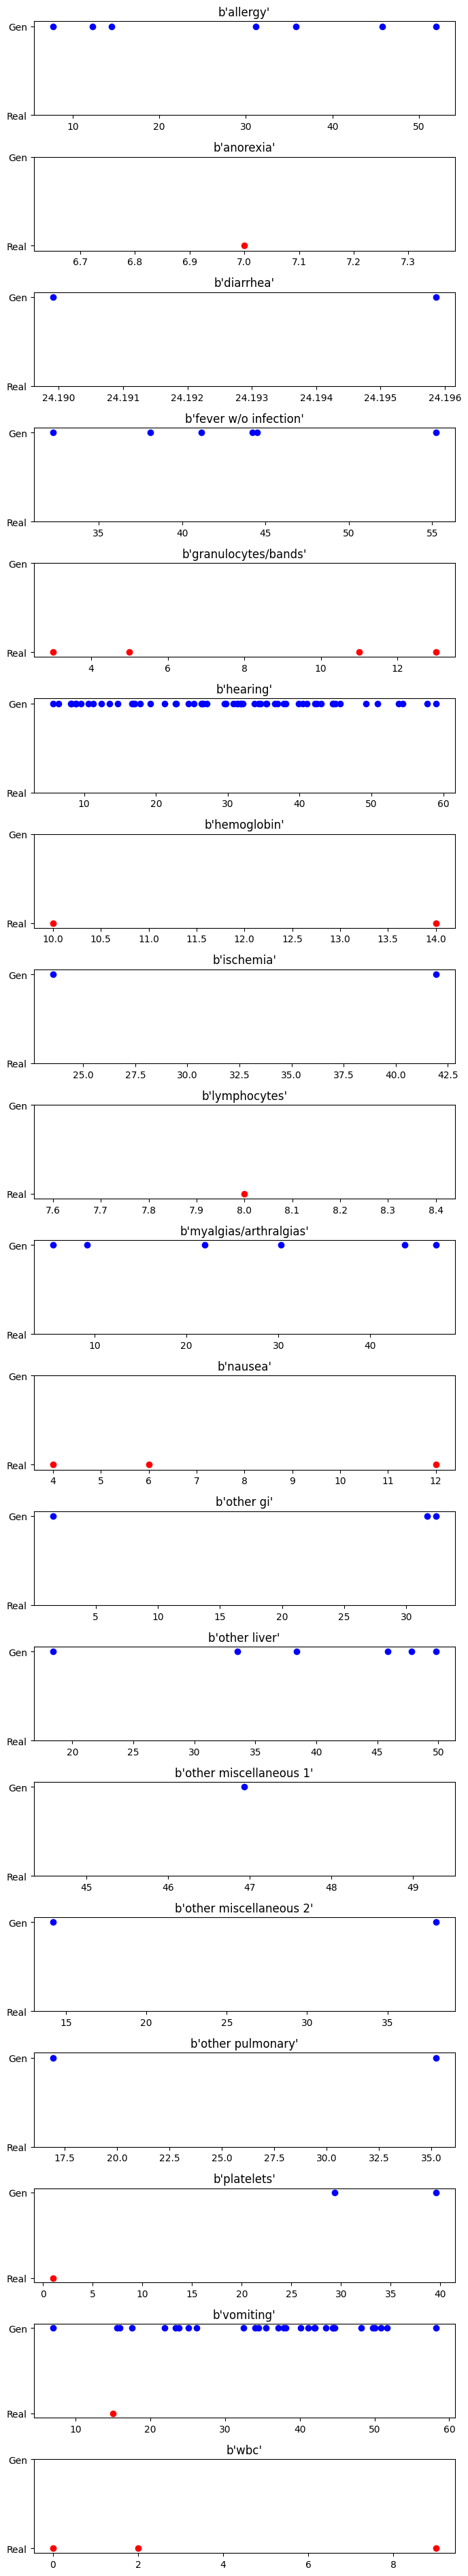

Done. Figure above shows real vs. generated times for events of patient 12727.


In [4]:
# Cell [4]: Actual usage for c9732 (NCT00003299) example

import pandas as pd
import torch
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch import Trainer

###################################
#  A) Load c9732_ae and c9732_demo
###################################
df_ae = pd.read_excel("/Users/mazinrafi/Downloads/c9732_ae.xlsx")  # adapt path
df_demo = pd.read_excel("/Users/mazinrafi/Downloads/c9732_demographic.xlsx")  # adapt path

# We'll define label=1 if STATUS=2, else 0
df_demo["label"] = df_demo["STATUS"].apply(lambda x: 1 if x==2 else 0)

# Instead of referencing a CYCLE column (which doesn't exist), 
# we'll define time by the row order within each patient:
df_ae["time"] = df_ae.groupby("PHATOM_ID").cumcount()

# Merge with the demo to get 'label' for each patient
df_merge = df_ae.merge(df_demo[["PHATOM_ID","label"]], on="PHATOM_ID", how="left")

# Rename columns to match code
df_merge = df_merge.rename(columns={
    "PHATOM_ID": "patient_id",
    "AE_NAME":    "event",
})

df_merge["value"] = 0.0
df_merge["event"] = df_merge["event"].astype(str)

# Keep columns in the final order the code expects
df_merge = df_merge[["patient_id","event","value","time","label"]]
df_merge = df_merge.sort_values(["patient_id","time"]).reset_index(drop=True)

print("Merged shape:", df_merge.shape)
print(df_merge.head())

###################################
#  B) Preprocess -> build "patients_list"
###################################
patient_id_col = "patient_id"
indicator_col  = "event"
value_num_col  = "value"
time_col       = "time"
label_col      = "label"

# OR if you have them in the same notebook, you can just call them directly without import

patients_list = process_patient_df(
    df_merge,
    patient_id_col, indicator_col, value_num_col, time_col, label_col
)
print("Number of patients:", len(patients_list))

patients_list, max_length, events2ind, ind2events, mean_t, std_t = preprocess_data(
    patients_list,
    max_length=None
)
print("max_length = ", max_length)
print("num_events = ", len(events2ind))

datamodule = EventDataModule(patients_list, batch_size=16)

###################################
#  C) Train the VAE + Hawkes
###################################
model = VAE(
    max_len=max_length,
    all_latent_dim=32*max_length,
    embedding_dim=128,
    num_embeddings=len(events2ind),
    end_token_ind=events2ind["[END]"]+1
)

trainer = Trainer(max_epochs=10, callbacks=[TQDMProgressBar(refresh_rate=20)], enable_checkpointing=False)
trainer.fit(model, datamodule=datamodule)

###################################
#  D) Generate & Plot for one patient
###################################
pid_of_interest = df_merge["patient_id"].unique()[0]
onepat_df = df_merge[df_merge["patient_id"]==pid_of_interest].copy()
onepat_list = [
    onepat_df[indicator_col].tolist(),
    onepat_df[value_num_col].tolist(),
    onepat_df[time_col].tolist(),
    int(onepat_df[label_col].iloc[0])
]

# Insert [END]
onepat_list[0].append("[END]")
onepat_list[1].append(0.0)
onepat_list[2].append(onepat_list[2][-1])

temp_list = [onepat_list]
temp_list, _, _, _, _, _ = preprocess_data(
    temp_list,
    max_length=max_length,
    events2ind=events2ind,
    ind2events=ind2events,
    mean_time=mean_t,
    std_time=std_t
)

model.eval()
with torch.no_grad():
    batch = temp_list[0]
    events_tensor = batch[0].unsqueeze(0)
    values_tensor = torch.tensor(batch[1]).unsqueeze(0)
    times_tensor  = batch[2].unsqueeze(0)
    label_val     = torch.tensor([batch[3]])
    out = model((events_tensor, values_tensor, times_tensor, label_val))
    type_pred, time_pred, hid, z, mu, std = out

type_pred = torch.softmax(type_pred, dim=-1).squeeze(0).cpu().numpy()
time_pred = time_pred.squeeze(0).squeeze(-1).cpu().numpy()
argmax_types = np.argmax(type_pred, axis=-1)
pred_event_names = [ind2events[a-1] if a>0 else "PAD" for a in argmax_types]
cumulative_time = np.cumsum(time_pred)*std_t

# Real data
real_events = onepat_df[indicator_col].tolist()
real_times  = onepat_df[time_col].tolist()

# Combined unique event names
all_events = sorted(set(real_events + pred_event_names) - set(["[END]","PAD"]))

# map real/pred
real_map = {}
for e,t in zip(real_events, real_times):
    real_map.setdefault(e, []).append(t)
pred_map = {}
for e,t in zip(pred_event_names, cumulative_time):
    if e in ("[END]","PAD"):
        break
    pred_map.setdefault(e, []).append(t)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(all_events), ncols=1, figsize=(7,2*len(all_events)))
if len(all_events) == 1:
    axes = [axes]

for ax, e_name in zip(axes, all_events):
    r_times = real_map.get(e_name, [])
    p_times = pred_map.get(e_name, [])
    ax.scatter(r_times, [0]*len(r_times), color='red', label='Real')
    ax.scatter(p_times, [1]*len(p_times), color='blue', label='Gen')
    ax.set_yticks([0,1]); ax.set_yticklabels(["Real","Gen"])
    ax.set_title(e_name)

plt.tight_layout()
plt.show()
print(f"Done. Figure above shows real vs. generated times for events of patient {pid_of_interest}.")


In [5]:
# Cell [5]: Generate Synthetic DataFrame from the trained model

def generate_synthetic_df(model, df_merge, events2ind, ind2events,
                          patient_id_col="patient_id", indicator_col="event",
                          value_num_col="value", time_col="time", label_col="label",
                          max_length=128, mean_time=1.0, std_time=1.0,
                          sample_factor=1):
    """
    For each real patient, we do a forward pass through the model to produce
    one synthetic sequence. Then we convert the synthetic sequence to a new DataFrame
    that has the same columns: patient_id, event, value, time, label.

    Arguments:
      model: A trained VAE model (or any baseline) that accepts a batch and outputs synthetic.
      df_merge: The real data DataFrame (used to iterate over patient IDs, plus label).
      events2ind, ind2events: event dictionaries for indexing
      sample_factor: if >1, we can generate multiple synthetic samples per real patient.

    Returns: gen_df, a DataFrame with the same columns as real.
    """
    all_syn_patients = []
    unique_pids = df_merge[patient_id_col].unique().tolist()

    # We'll assume we generate 1 synthetic for each real patient
    for pid in unique_pids:
        # extract that patient's data
        sub = df_merge[df_merge[patient_id_col] == pid]
        if len(sub) == 0:
            continue
        label_ = int(sub[label_col].iloc[0])

        # build a single "patient_list" entry
        events_list = sub[indicator_col].tolist()
        values_list = sub[value_num_col].tolist()
        times_list  = sub[time_col].tolist()

        # add [END] + pad last time
        events_list.append("[END]")
        values_list.append(values_list[-1])
        times_list.append(times_list[-1])

        # convert to numeric
        e_idx = [events2ind[e] + 1 for e in events_list]
        # NOTE: pad if needed, but let's just do a single pass (assuming short sequences).
        e_idx = e_idx[:max_length] + [0]*(max_length - len(e_idx))
        t_list = times_list[:max_length] + [0]*(max_length - len(times_list))
        t_list = np.array(t_list) / std_time
        v_list = values_list[:max_length] + [0]*(max_length - len(values_list))

        # Turn into Tensors [1, seq_len]
        events_tensor = torch.tensor(e_idx).unsqueeze(0).long()
        values_tensor = torch.tensor(v_list).unsqueeze(0).float()
        times_tensor  = torch.tensor(t_list).unsqueeze(0).float()
        label_tensor  = torch.tensor([label_])

        with torch.no_grad():
            type_pred, time_pred, hid36, z, mu, std = model((events_tensor, values_tensor, times_tensor, label_tensor))
            # shape: type_pred => [1, seq_len, num_types]
            # time_pred => [1, seq_len, 1]

        # convert type_pred to argmax
        type_pred_soft = torch.softmax(type_pred, dim=-1).squeeze(0).cpu().numpy()
        argmax_ = np.argmax(type_pred_soft, axis=-1)
        # convert to event names
        syn_events = [ind2events[a-1] if a>0 else "[PAD]" for a in argmax_]

        # convert time_pred by cumsum
        time_pred = time_pred.squeeze(0).squeeze(-1).cpu().numpy()
        cumsum_ = np.cumsum(time_pred) * std_time

        # build new list for this synthetic
        new_seq = []
        for e_, t_ in zip(syn_events, cumsum_):
            if e_ in ("[END]", "[PAD]"):
                break
            new_seq.append((e_, 0.0, t_, label_))

        # store in a list form => We'll parse after
        # we keep patient_id as a new ID (like "synthetic_{pid}")
        syn_pid = f"syn_{pid}"
        pat_data = []
        for (ee, vv, tt, ll) in new_seq:
            pat_data.append((syn_pid, ee, vv, tt, ll))

        all_syn_patients.extend(pat_data)

    # now build a DataFrame
    gen_df = pd.DataFrame(all_syn_patients,
                          columns=[patient_id_col, indicator_col, value_num_col, time_col, label_col])
    gen_df = gen_df.sort_values([patient_id_col, time_col]).reset_index(drop=True)
    return gen_df


In [6]:
# after training the model in cell [4], generate synthetic
gen_df = generate_synthetic_df(
    model, 
    df_merge, 
    events2ind, 
    ind2events,
    max_length=max_length,
    mean_time=mean_t,
    std_time=std_t
)

print("Synthetic data shape:", gen_df.shape)
print(gen_df.head(10))


Synthetic data shape: (72472, 5)
  patient_id        event  value       time  label
0  syn_12727   b'hearing'    0.0 -55.250313      1
1  syn_12727  b'vomiting'    0.0 -55.009758      1
2  syn_12727   b'hearing'    0.0 -54.832706      1
3  syn_12727  b'vomiting'    0.0 -53.908768      1
4  syn_12727  b'vomiting'    0.0 -53.456753      1
5  syn_12727   b'hearing'    0.0 -53.139252      1
6  syn_12727  b'vomiting'    0.0 -51.766838      1
7  syn_12727  b'ischemia'    0.0 -50.704617      1
8  syn_12727   b'hearing'    0.0 -50.440628      1
9  syn_12727   b'hearing'    0.0 -48.717052      1


In [7]:
# Cell [6]: Compute the Utility (ROCAUC) for c9732

from sklearn.metrics import roc_auc_score
import random

def prepare_dataset_for_lstm(df, patient_id_col="patient_id", event_col="event",
                             value_col="value", time_col="time", label_col="label"):
    """
    Convert a dataFrame into a 'list of patients' format for the LSTM classification.
    We'll just re-use process_patient_df + preprocess_data from earlier.
    """
    pat_list = process_patient_df(df, patient_id_col, event_col, value_col, time_col, label_col)
    pat_list, ml, e2i, i2e, mt, st = preprocess_data(pat_list, max_length=None)
    return pat_list, ml, e2i, i2e, mt, st

def train_downstream_classifier(syn_df, real_df, patient_id_col="patient_id",
                                event_col="event", value_col="value",
                                time_col="time", label_col="label",
                                num_epochs=5, hidden_size=64):
    """
    1. We'll prepare the synthetic data as the 'train' set
    2. We'll pick a test set from the real data
    3. We'll train an LSTM classifier on synthetic, then evaluate on real test => compute ROCAUC
    """

    # A. prepare synthetic
    syn_list, syn_ml, syn_e2i, syn_i2e, syn_mt, syn_st = prepare_dataset_for_lstm(
        syn_df, patient_id_col, event_col, value_col, time_col, label_col
    )
    syn_data = DataLoader(PatientDataset(syn_list), batch_size=8, shuffle=True)

    # B. prepare real - we do a simple random 80/20 split for test
    #   (in practice, the paper might do a more careful split, but let's keep it simple)
    real_pids = list(real_df[patient_id_col].unique())
    random.shuffle(real_pids)
    test_size = int(0.2 * len(real_pids))
    test_pids = set(real_pids[:test_size])
    train_pids= set(real_pids[test_size:]) # not used for training here, though

    # The paper's logic: "We do NOT train LSTM on real. We only test on real."
    # We'll just gather the test set as a separate list
    test_df = real_df[real_df[patient_id_col].isin(test_pids)].copy()
    test_list, test_ml, test_e2i, test_i2e, test_mt, test_st = prepare_dataset_for_lstm(
        test_df, patient_id_col, event_col, value_col, time_col, label_col
    )

    test_data = DataLoader(PatientDataset(test_list), batch_size=8, shuffle=False)

    # We'll unify the number of events for the LSTM's embedding dimension
    # => pick the bigger from syn_e2i vs test_e2i
    # for simplicity let's pick max
    vocab_size = max(len(syn_e2i), len(test_e2i))
    # define the LSTM predictor
    classifier = LSTMPredictor(num_embeddings=vocab_size, hidden_size=hidden_size)

    # C. train on synthetic
    trainer = pl.Trainer(max_epochs=num_epochs, enable_checkpointing=False, logger=False)
    trainer.fit(model=classifier, train_dataloaders=syn_data)

    # D. predict on real test
    preds = trainer.predict(model=classifier, dataloaders=test_data)
    preds = torch.cat(preds, dim=0).cpu().squeeze().numpy()

    # gather ground truth labels
    test_labels = [test_list[i][3] for i in range(len(test_list))]

    # E. compute roc auc
    rocauc = roc_auc_score(test_labels, preds)
    return rocauc, preds, test_labels



In [8]:
# Suppose we have `df_merge` as the real data and `gen_df` as the synthetic
# from the previous cell. Now let's compute the utility AUC.

rocauc, preds, labels = train_downstream_classifier(gen_df, df_merge, num_epochs=5, hidden_size=64)
print("Utility ROCAUC on c9732 (LC1):", rocauc)


/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available:

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Utility ROCAUC on c9732 (LC1): 0.6123853211009175


In [9]:
# Cell [7]: ML Inference Score

from sklearn.metrics import roc_auc_score

def ml_inference_score(real_df, syn_df,
                       patient_id_col="patient_id",
                       event_col="event",
                       value_col="value",
                       time_col="time",
                       label_col="label",
                       epochs=5, hidden_size=64):
    """
    1) Label real data with rs_label=0, synthetic data with rs_label=1
    2) Combine them, shuffle
    3) Create sequences for an LSTM-based classifier
    4) Train the LSTM on part of the data and test on another (80/20) 
       to see how well it can separate real vs. synthetic
    5) Return the ROC AUC (closer to 0.5 => more private)
    """

    # A. Tag them
    real_df = real_df.copy()
    real_df["rs_label"] = 0
    syn_df = syn_df.copy()
    syn_df["rs_label"]  = 1

    # B. Combine
    combined_df = pd.concat([real_df, syn_df], axis=0).reset_index(drop=True)

    # We'll create a new function that uses 'rs_label' as the classification target
    # We'll rename 'label' to something else to avoid confusion
    # or we just ignore it and rely on 'rs_label' only
    combined_df["orig_label"] = combined_df[label_col]  # keep old label if needed

    # We'll define a helper to build sequences from 'rs_label' now
    # We'll do a minimal version similar to process_patient_df, but we store 'rs_label' instead of 'label'
    def process_df_for_inference(df):
        df_list = df.groupby(patient_id_col).apply(
            lambda x: [
                x[event_col].tolist(),
                x[value_col].tolist(),
                x[time_col].tolist(),
                x["rs_label"].values[0]  # the real vs. synthetic label for that patient
            ]
        ).tolist()
        return df_list

    # create the list
    comb_list = process_df_for_inference(combined_df)

    # Pad, etc. reusing existing logic
    comb_list, ml, e2i, i2e, mt, st = preprocess_data(comb_list, max_length=None)

    # We'll do a random train/test 80/20
    import random
    random.shuffle(comb_list)
    split_idx = int(len(comb_list)*0.8)
    train_list = comb_list[:split_idx]
    test_list  = comb_list[split_idx:]

    train_dl = DataLoader(PatientDataset(train_list), batch_size=8, shuffle=True)
    test_dl  = DataLoader(PatientDataset(test_list),  batch_size=8, shuffle=False)

    vocab_size = len(e2i)
    # define a simple LSTM classifier for real-vs-syn label
    classifier = LSTMPredictor(num_embeddings=vocab_size, hidden_size=hidden_size)

    trainer = pl.Trainer(max_epochs=epochs, enable_checkpointing=False, logger=False)
    trainer.fit(model=classifier, train_dataloaders=train_dl)

    # predict on test
    preds = trainer.predict(classifier, test_dl)
    preds = torch.cat(preds, dim=0).cpu().numpy().squeeze()

    # gather test labels
    test_labels = [t[3] for t in test_list]  # the 'rs_label'
    auc_val = roc_auc_score(test_labels, preds)
    return auc_val


In [10]:
# Suppose we have df_merge (real) and gen_df (synthetic).
rs_auc = ml_inference_score(df_merge, gen_df, epochs=5)
print("ML Inference Score (AUC). Closer to 0.5 => better privacy:", rs_auc)


/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1757795076.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type      | Params | Mode 
---------------------------------------------
0 | emb    | Embedding | 2.4 K  | train
1 | lstm   | LSTM      | 33.3 K | train
2 | linear | Linear    | 65     | train
---------------------------------------------
35.7 K    Trainable params
0         Non-trainable params
35.7 K    Total params
0.143     Total estimated model params size (MB)
3         Modules in train mode
0 

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

ML Inference Score (AUC). Closer to 0.5 => better privacy: 1.0


In [11]:
# Cell [8]: Distance to Closest Record (DCR)

import math

def featurize_events(df, patient_id_col="patient_id", event_col="event", time_col="time"):
    """
    Build a dictionary: pid -> (count_of_events, mean_time, std_time)
    for each patient. 
    Simple approach: ignore event type variety, just count them.
    """
    feat_dict = {}
    for pid, subdf in df.groupby(patient_id_col):
        times = subdf[time_col].values
        c = len(times)
        m = times.mean() if c>0 else 0
        s = times.std() if c>1 else 0
        feat_dict[pid] = (c, m, s)
    return feat_dict

def compute_dcr(real_df, syn_df,
                patient_id_col="patient_id", event_col="event", time_col="time"):
    """
    1) featurize real -> real_feat
    2) featurize syn -> syn_feat
    3) for each syn patient, compute L2 distance to each real patient, take min
    4) average these mins
    """
    real_feat = featurize_events(real_df, patient_id_col, event_col, time_col)
    syn_feat  = featurize_events(syn_df, patient_id_col, event_col, time_col)

    real_keys = list(real_feat.keys())
    syn_keys  = list(syn_feat.keys())

    real_vecs = np.array([real_feat[k] for k in real_keys])
    syn_vecs  = np.array([syn_feat[k]  for k in syn_keys])

    # For each synthetic vector, compute min L2 distance to real vectors
    dcr_list = []
    for v in syn_vecs:
        dists = np.sqrt(np.sum((real_vecs - v)**2, axis=1))
        min_dist = dists.min()
        dcr_list.append(min_dist)

    return np.mean(dcr_list)


In [12]:
# compute DCR for LC1
dcr_value = compute_dcr(df_merge, gen_df)
print("Distance to Closest Record:", dcr_value)


Distance to Closest Record: 44.352346027975564


In [13]:
# Cell [9]: Dataset Attack

def dataset_attack(real_df, syn_df,
                   patient_id_col="patient_id", event_col="event", time_col="time"):
    """
    We'll compute the same feature vectors as DCR:
    (count_of_events, mean_time, std_time), or more if needed.
    Then combine real + synthetic. For each real record, find the single closest
    record in that combined set. 
    If that closest is synthetic => label=1, else 0. Then we return the fraction of 1's.

    The paper wants ~ 0.5 ideally.
    """

    # 1) build feats
    real_feat = featurize_events(real_df, patient_id_col, event_col, time_col)
    syn_feat  = featurize_events(syn_df,  patient_id_col, event_col, time_col)

    # 2) combine
    all_keys  = list(real_feat.keys()) + list(syn_feat.keys())
    all_feats = [real_feat[k] for k in real_feat.keys()] + [syn_feat[k] for k in syn_feat.keys()]
    all_vecs  = np.array(all_feats)

    # We'll store an index range to identify real vs syn
    real_count = len(real_feat)
    syn_count  = len(syn_feat)

    # For each real subject i in [0..real_count-1], find the min distance in [0..(real+syn)-1].
    # If that min index >= real_count, it means the closest is synthetic.
    # We'll skip the distance to itself (which is 0).
    # Implementation detail: We can do a quick brute force or fancy approach.

    real_keys = list(real_feat.keys())
    real_vecs = all_vecs[:real_count]

    hits = 0
    for i in range(real_count):
        rvec = real_vecs[i]
        # measure distance to all
        dists = np.sqrt(np.sum((all_vecs - rvec)**2, axis=1))
        dists[i] = 1e9  # ignore itself in the real list
        min_idx = np.argmin(dists)
        # if min_idx >= real_count => synthetic
        if min_idx >= real_count:
            hits += 1

    # fraction
    fraction = hits / real_count
    return fraction


In [14]:
attack_val = dataset_attack(df_merge, gen_df)
print("Dataset Attack fraction. (closer to 0.5 => more private):", attack_val)


Dataset Attack fraction. (closer to 0.5 => more private): 0.0034071550255536627


In [ ]:
#above seems to have failed. Let's try again

/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Merged shape: (20268, 5)
   patient_id                  event  value  time  label
0       12727                 b'wbc'    0.0     0      1
1       12727           b'platelets'    0.0     1      1
2       12727                 b'wbc'    0.0     2      1
3       12727  b'granulocytes/bands'    0.0     3      1
4       12727              b'nausea'    0.0     4      1
Number of patients: 587
max_length =  128
num_events =  36



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | ts_encoder     | TransformerHawkes | 108 K  | train
1 | decoder_linear | Sequential        | 21.0 K | train
2 | hawkes_out     | Linear            | 4.6 K  | train
3 | fc_mu          | Sequential        | 4.1 K  | train
4 | fc_var         | Sequential        | 4.1 K  | train
-------------------------------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.570     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/3951018379.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values_tensor = torch.tensor(batch[1]).unsqueeze(0)


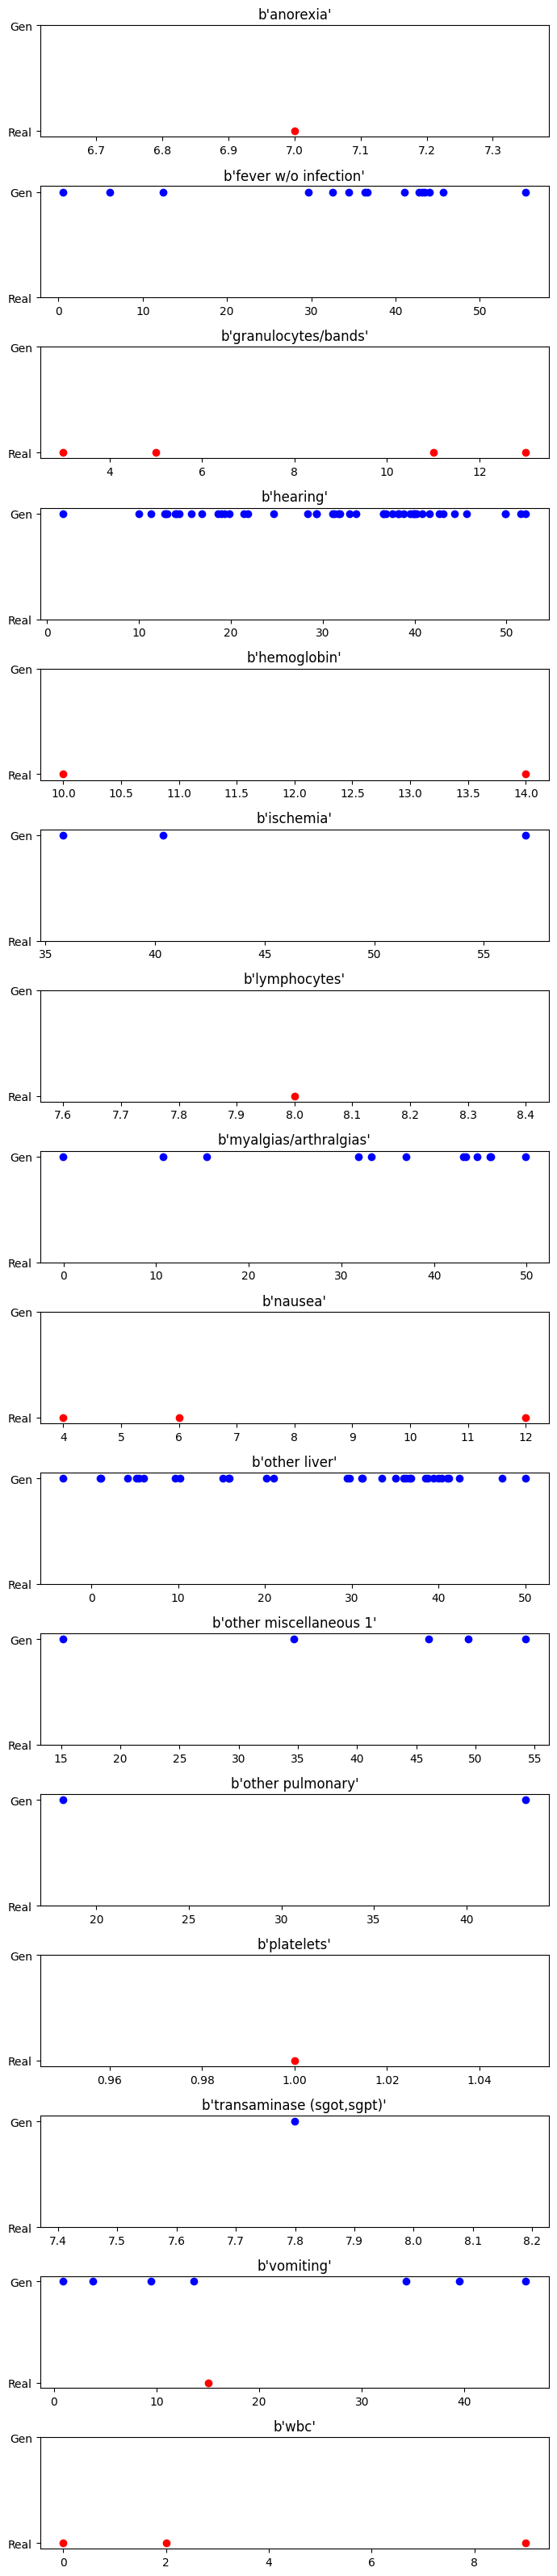

Done. Figure above shows real vs. generated times for events of patient 12727.


In [20]:
# A) Scale the time column more aggressively
# e.g., if time ranges up to 200 or 300, dividing it down to 0-20 range:
df_merge["time"] = df_merge["time"]  # change and experiment

# B) Adjust var_multiplier inside your VAE or after training
# If code references self.var_multiplier somewhere, set it <1.0
model.var_multiplier = 2

import pandas as pd
import torch
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch import Trainer

###################################
#  A) Load c9732_ae and c9732_demo
###################################
df_ae = pd.read_excel("/Users/mazinrafi/Downloads/c9732_ae.xlsx")  # adapt path
df_demo = pd.read_excel("/Users/mazinrafi/Downloads/c9732_demographic.xlsx")  # adapt path

# We'll define label=1 if STATUS=2, else 0
df_demo["label"] = df_demo["STATUS"].apply(lambda x: 1 if x==2 else 0)

# Instead of referencing a CYCLE column (which doesn't exist), 
# we'll define time by the row order within each patient:
df_ae["time"] = df_ae.groupby("PHATOM_ID").cumcount()

# Merge with the demo to get 'label' for each patient
df_merge = df_ae.merge(df_demo[["PHATOM_ID","label"]], on="PHATOM_ID", how="left")

# Rename columns to match code
df_merge = df_merge.rename(columns={
    "PHATOM_ID": "patient_id",
    "AE_NAME":    "event",
})

df_merge["value"] = 0.0
df_merge["event"] = df_merge["event"].astype(str)

# Keep columns in the final order the code expects
df_merge = df_merge[["patient_id","event","value","time","label"]]
df_merge = df_merge.sort_values(["patient_id","time"]).reset_index(drop=True)

print("Merged shape:", df_merge.shape)
print(df_merge.head())

###################################
#  B) Preprocess -> build "patients_list"
###################################
patient_id_col = "patient_id"
indicator_col  = "event"
value_num_col  = "value"
time_col       = "time"
label_col      = "label"

# OR if you have them in the same notebook, you can just call them directly without import

patients_list = process_patient_df(
    df_merge,
    patient_id_col, indicator_col, value_num_col, time_col, label_col
)
print("Number of patients:", len(patients_list))

patients_list, max_length, events2ind, ind2events, mean_t, std_t = preprocess_data(
    patients_list,
    max_length=None
)
print("max_length = ", max_length)
print("num_events = ", len(events2ind))

datamodule = EventDataModule(patients_list, batch_size=16)

###################################
#  C) Train the VAE + Hawkes
###################################
model = VAE(
    max_len=max_length,
    all_latent_dim=32*max_length,
    embedding_dim=128,
    num_embeddings=len(events2ind),
    end_token_ind=events2ind["[END]"]+1
)

trainer = Trainer(max_epochs=10, callbacks=[TQDMProgressBar(refresh_rate=20)], enable_checkpointing=False)
trainer.fit(model, datamodule=datamodule)

###################################
#  D) Generate & Plot for one patient
###################################
pid_of_interest = df_merge["patient_id"].unique()[0]
onepat_df = df_merge[df_merge["patient_id"]==pid_of_interest].copy()
onepat_list = [
    onepat_df[indicator_col].tolist(),
    onepat_df[value_num_col].tolist(),
    onepat_df[time_col].tolist(),
    int(onepat_df[label_col].iloc[0])
]

# Insert [END]
onepat_list[0].append("[END]")
onepat_list[1].append(0.0)
onepat_list[2].append(onepat_list[2][-1])

temp_list = [onepat_list]
temp_list, _, _, _, _, _ = preprocess_data(
    temp_list,
    max_length=max_length,
    events2ind=events2ind,
    ind2events=ind2events,
    mean_time=mean_t,
    std_time=std_t
)

model.eval()
with torch.no_grad():
    batch = temp_list[0]
    events_tensor = batch[0].unsqueeze(0)
    values_tensor = torch.tensor(batch[1]).unsqueeze(0)
    times_tensor  = batch[2].unsqueeze(0)
    label_val     = torch.tensor([batch[3]])
    out = model((events_tensor, values_tensor, times_tensor, label_val))
    type_pred, time_pred, hid, z, mu, std = out

type_pred = torch.softmax(type_pred, dim=-1).squeeze(0).cpu().numpy()
time_pred = time_pred.squeeze(0).squeeze(-1).cpu().numpy()
argmax_types = np.argmax(type_pred, axis=-1)
pred_event_names = [ind2events[a-1] if a>0 else "PAD" for a in argmax_types]
cumulative_time = np.cumsum(time_pred)*std_t

# Real data
real_events = onepat_df[indicator_col].tolist()
real_times  = onepat_df[time_col].tolist()

# Combined unique event names
all_events = sorted(set(real_events + pred_event_names) - set(["[END]","PAD"]))

# map real/pred
real_map = {}
for e,t in zip(real_events, real_times):
    real_map.setdefault(e, []).append(t)
pred_map = {}
for e,t in zip(pred_event_names, cumulative_time):
    if e in ("[END]","PAD"):
        break
    pred_map.setdefault(e, []).append(t)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(all_events), ncols=1, figsize=(7,2*len(all_events)))
if len(all_events) == 1:
    axes = [axes]

for ax, e_name in zip(axes, all_events):
    r_times = real_map.get(e_name, [])
    p_times = pred_map.get(e_name, [])
    ax.scatter(r_times, [0]*len(r_times), color='red', label='Real')
    ax.scatter(p_times, [1]*len(p_times), color='blue', label='Gen')
    ax.set_yticks([0,1]); ax.set_yticklabels(["Real","Gen"])
    ax.set_title(e_name)

plt.tight_layout()
plt.show()
print(f"Done. Figure above shows real vs. generated times for events of patient {pid_of_interest}.")


In [18]:
# Cell [5A]: Utility (ROCAUC) with repeated runs, consistent train/test splits

import random
import numpy as np
from sklearn.metrics import roc_auc_score

def train_downstream_classifier_repeated(
    syn_df,
    real_df,
    patient_id_col="patient_id",
    event_col="event",
    value_col="value",
    time_col="time",
    label_col="label",
    num_epochs=5,
    hidden_size=64,
    n_runs=5,
    test_ratio=0.2,
    random_seeds=(42,43,44,45,46)
):
    """
    Repeated approach:
      1) For each run (with a different random seed):
         - pick a random test set from real (test_ratio)
         - train LSTM on synthetic
         - measure ROC AUC on real test
      2) Collect the AUCs and return mean ± std.
    """

    # Prepare the synthetic data => used for training every run
    syn_list, syn_ml, syn_e2i, syn_i2e, syn_mt, syn_st = prepare_dataset_for_lstm(
        syn_df, patient_id_col, event_col, value_col, time_col, label_col
    )
    syn_data = DataLoader(PatientDataset(syn_list), batch_size=8, shuffle=True)

    rocs = []

    pid_list = list(real_df[patient_id_col].unique())
    for run_i, seed_val in enumerate(random_seeds):
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        # pick test set
        random.shuffle(pid_list)
        test_n = int(len(pid_list)*test_ratio)
        test_pids = set(pid_list[:test_n])
        test_df = real_df[real_df[patient_id_col].isin(test_pids)].copy()

        # build test list
        test_list, _, _, _, _, _ = prepare_dataset_for_lstm(
            test_df, patient_id_col, event_col, value_col, time_col, label_col
        )
        test_data = DataLoader(PatientDataset(test_list), batch_size=8, shuffle=False)

        # unify vocab size
        vocab_size = max(len(syn_e2i), 1)
        # define classifier
        classifier = LSTMPredictor(num_embeddings=vocab_size, hidden_size=hidden_size)

        trainer = pl.Trainer(max_epochs=num_epochs, enable_checkpointing=False, logger=False)
        # fit on synthetic
        trainer.fit(model=classifier, train_dataloaders=syn_data)

        # predict on real test
        preds = trainer.predict(model=classifier, dataloaders=test_data)
        preds = torch.cat(preds, dim=0).cpu().squeeze().numpy()
        true_labels = [test_list[ii][3] for ii in range(len(test_list))]
        auc_val = roc_auc_score(true_labels, preds)
        rocs.append(auc_val)

    mean_ = np.mean(rocs)
    std_  = np.std(rocs)
    return mean_, std_

def prepare_dataset_for_lstm(df, patient_id_col, event_col, value_col, time_col, label_col):
    pat_list = process_patient_df(df, patient_id_col, event_col, value_col, time_col, label_col)
    pat_list, ml, e2i, i2e, mt, st = preprocess_data(pat_list, max_length=None)
    return pat_list, ml, e2i, i2e, mt, st


In [19]:
#let's say we have gen_df from the model:
mean_roc, std_roc = train_downstream_classifier_repeated(
    syn_df=gen_df,
    real_df=df_merge,
    num_epochs=5,
    n_runs=5
)
print(f"Utility ROCAUC on c9732: {mean_roc:.3f} ± {std_roc:.3f}")


/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available:

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type      | Params | Mode 
---------------------------------------------
0 | emb    | Embedding | 1.5 K  | train
1 | lstm   | LSTM      | 33.3 K | train
2 | linear | Linear    | 65     | train
---------------------------------------------
34.8 K    Trainable params
0         Non-trainable params
34.8 K    Total params
0.139     Total estimated model params size (MB)
3         Modules in train m

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type      | Params | Mode 
---------------------------------------------
0 | emb    | Embedding | 1.5 K  | train
1 | lstm   | LSTM      | 33.3 K | train
2 | linear | Linear    | 65     | train
---------------------------------------------
34.8 K    Trainable params
0         Non-trainable params
34.8 K    Total params
0.139     Total estimated model params size (MB)
3         Modules in train m

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type      | Params | Mode 
---------------------------------------------
0 | emb    | Embedding | 1.5 K  | train
1 | lstm   | LSTM      | 33.3 K | train
2 | linear | Linear    | 65     | train
---------------------------------------------
34.8 K    Trainable params
0         Non-trainable params
34.8 K    Total params
0.139     Total estimated model params size (MB)
3         Modules in train m

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_96336/1925828069.py:317: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_list = df.groupby(patient_id_col).apply(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type      | Params | Mode 
---------------------------------------------
0 | emb    | Embedding | 1.5 K  | train
1 | lstm   | LSTM      | 33.3 K | train
2 | linear | Linear    | 65     | train
---------------------------------------------
34.8 K    Trainable params
0         Non-trainable params
34.8 K    Total params
0.139     Total estimated model params size (MB)
3         Modules in train m

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
/Users/mazinrafi/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Utility ROCAUC on c9732: 0.515 ± 0.078
